In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys 
from pickle import dump, load
import re
from math import sqrt, factorial
from time import time
from collections import namedtuple
import argparse
from urllib.request import urlopen

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
POINTS_PATH = 'points/'

In [5]:
def oracle(array, fname = 'final_samples.txt'):
    url = 'http://185.86.144.8/oracle?x1={:f}&x2={:f}&x3={:f}&x4={:f}&x5={:f}&x6={:f}&x7={:f}&x8={:f}&x9={:f}&x10={:f}'.format(
        *array)

    with urlopen(url) as response, open(POINTS_PATH + fname, 'a') as out_file:
        data = response.read().decode('utf-8')
        out_file.write(str(array) + '\t' + data + '\n')
        parsed_data = re.split(r'^Function value = |\nAttempts left = ', data)
        if (data != 'UNDIFINED'):
            result, attempts = [np.float(number)
                                for number in parsed_data if number]

        else:
            return np.inf

    return result

In [300]:
def get_samples(number, oracle_func, fname = 'test_samples_log.txt'):
    array = 10 * np.random.random_sample((number, 11))
    for i in range(len(array)):
        array[i, 0] = oracle(array[i, 1:], fname)
    return array

In [329]:
test_data1 = get_samples(90000, oracle)

In [328]:
test_data.shape

(10000, 11)

In [330]:
total_test = np.concatenate((test_data,test_data1), axis = 0)

In [331]:
np.savetxt('test_samples.txt', total_test)

In [ ]:
ar = np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
oracle(ar,'dump.txt')

In [96]:
total_test = np.loadtxt('test_samples.txt')

In [6]:
train_data = np.loadtxt('points/sampled_points.txt')

In [ ]:
#Data work end

In [324]:
def visualize_data(total_data,num1,num2):
    pca = PCA(n_components=2)
    projection = pca.fit_transform(total_data)

    plt.figure(figsize=(8, 8))

    plt.rcParams['legend.fontsize'] = 10
    plt.scatter(projection[num1:num2, 0], projection[num1:num2, 1],
              color='blue', alpha=0.1, label='Train')
    plt.title('reg data')
    plt.show()

In [325]:
biggest_data.shape

(207024, 14)

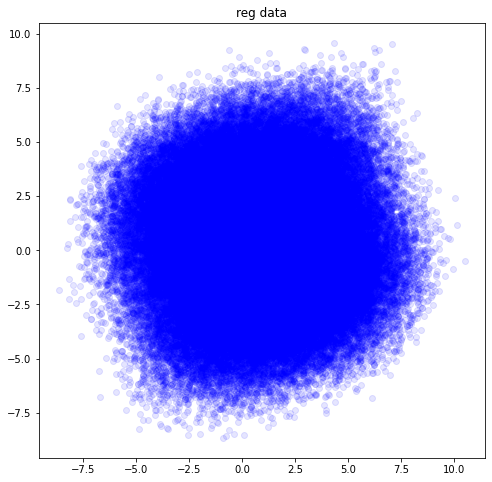

In [347]:
#Visualize data qt inline
%matplotlib inline
visualize_data(biggest_data[:,1:11],0,100000)

In [8]:
def expand_data(test_data, selected_features = None, verbose = True, To_Torch = False):
    if selected_features is None:
        selected_features = np.arange(11,236)
    else:
        selected_features = selected_features + 1
    test_data_e = np.empty((len(test_data),len(selected_features) + 11), dtype = test_data.dtype)
    test_data_e[:,:11] = test_data
    features_add = []
    features_sub = []
    features_multiply = []
    features_divide1 = []
    features_divide2 = []
    k = 11
    for i in range(1, 11):
        for j in range(i+1,11):
            if k in selected_features:
                features_add.append([i,j,k])
            if k+1 in selected_features:
                features_sub.append([i,j,k+1]) 
            if k+2 in selected_features:
                features_multiply.append([i,j,k+2])
            if k+3 in selected_features:
                features_divide1.append([i,j,k+3])
            if k+4 in selected_features:
                features_divide2.append([j,i,k+4])
            k += 5
    k = 11
    if len(selected_features) == 225:
        for i in range(45):
            test_data_e[:,k] = test_data_e[:,features_add[i][0]] + test_data_e[:,features_add[i][1]]
            test_data_e[:,k+1] = test_data_e[:,features_sub[i][0]] - test_data_e[:,features_sub[i][1]]
            test_data_e[:,k+2] = test_data_e[:,features_multiply[i][0]] * test_data_e[:,features_multiply[i][1]]
            test_data_e[:,k+3] = (test_data_e[:,features_divide1[i][0]] + 1e-7) / (test_data_e[:,features_divide1[i][1]] + 1e-7)
            test_data_e[:,k+4] = (test_data_e[:,features_divide2[i][0]] + 1e-7) / (test_data_e[:,features_divide2[i][1]] + 1e-7)
            k += 5
        if verbose:
            for i in range(45):
                print(f'{features_add[i][2]-1} feature is adding x{features_add[i][0]} and x{features_add[i][1]}')
                print(f'{features_sub[i][2]-1} feature is substracting x{features_sub[i][1]} from x{features_sub[i][0]}')
                print(f'{features_multiply[i][2]-1} feature is multiplying x{features_multiply[i][0]} and x{features_multiply[i][1]}')
                print(f'{features_divide1[i][2]-1} feature is dividing x{features_divide1[i][0]} by x{features_divide1[i][1]}')
                print(f'{features_divide2[i][2]-1} feature is dividing x{features_divide2[i][0]} by x{features_divide2[i][1]}')

    else:
        for pair in features_add:
            test_data_e[:,k] = test_data_e[:,pair[0]] + test_data_e[:,pair[1]]
            k += 1
            if verbose:
                print(f'{pair[2]-1} feature is adding x{pair[0]} and x{pair[1]}')
        for pair in features_sub:
            test_data_e[:,k] = test_data_e[:,pair[0]] + test_data_e[:,pair[1]]
            k += 1
            if verbose:
                print(f'{pair[2]-1} feature is substracting x{pair[1]} from x{pair[0]}')
        for pair in features_multiply:
            test_data_e[:,k] = test_data_e[:,pair[0]]*test_data_e[:,pair[1]]
            k += 1
            if verbose:
                print(f'{pair[2]-1} feature is multiplying x{pair[0]} and x{pair[1]}')
        for pair in features_divide1:
            test_data_e[:,k] = (test_data_e[:,pair[0]] + 1e-7)/(test_data_e[:,pair[1]] + 1e-7)
            k += 1
            if verbose:
                print(f'{pair[2]-1} feature is dividing x{pair[0]} by x{pair[1]}')
        for pair in features_divide2:
            test_data_e[:,k] = (test_data_e[:,pair[0]] + 1e-7)/(test_data_e[:,pair[1]] + 1e-7)
            k += 1
            if verbose:
                print(f'{pair[2]-1} feature is dividing x{pair[0]} by x{pair[1]}')

    if To_Torch:
        te_x = torch.from_numpy(test_data_e[:,1:]).to('cuda').float()
        te_y = torch.from_numpy(test_data_e[:,0]).to('cuda').view((-1,1)).float()
        return te_x, te_y
    else:
        return test_data_e

In [8]:
ultimate_features = np.array([93,92,75])

In [ ]:
#XGBoost

In [9]:
new_data = expand_data(train_data, selected_features = ultimate_features)

75 feature is adding x2 and x7
92 feature is multiplying x2 and x10
93 feature is dividing x2 by x10


In [285]:
dtrain = xgb.DMatrix(np.copy(new_data[:,1:]), label=np.copy(new_data[:,0]))

0.02094411849975586


In [ ]:
#dtrain = xgb.DMatrix(np.copy(train_data[:,1:]), label=np.copy(train_data[:,0]))

In [369]:
param = {'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
param['verbose_eval'] = 1000
param['verbosity'] = 1
evallist = [(dtrain, 'test')]

In [ ]:
#ultimate_features = [0,1,3,2,93,183,4,6,5,92,77,7,9,75,8]
#ultimate_features = [93,183,92,77,75]

In [ ]:
#XGBoost end

In [108]:
DATA_DIR = 'data/'
class ActiveLearner:

    def __init__(self, oracle_function, steps=20, dimension=10, 
                 expand_features = None, initial=0, pre_train_data = None,
                 learner_class='XGBRegressor', comittee_size=5, points_per_iter = 1000, 
                 n_rounds = 1000, eval_data = None, sample_pool = None, sampled = False,
                 sample_mask = None, returnmode = False):
        self.sample_pool = sample_pool
        self.returnmode = returnmode
        if sample_mask is None:
            self.sample_mask = np.ones(len(sample_pool),dtype = np.bool)
        else:
            self.sample_mask = sample_mask
        self.sampled = sampled
        self.eval_data = eval_data # already expanded
        self.oracle_function = oracle_function
        self.steps = steps
        self.n_points = points_per_iter
        self.n_rounds = n_rounds
        if expand_features is None:
            self.dimension = dimension
        else:
            self.expand_features = expand_features
            self.dimension = dimension + len(expand_features)
        self.initial = initial
        self.iteration = self.initial
        self.learner_class = learner_class
        self.comittee_size = comittee_size
        self.x_scale = 1
        self.y_scale = 1
        self.deval = xgb.DMatrix(np.copy(self.eval_data[:,1:]), label=np.copy(self.eval_data[:,0]))
        
        if pre_train_data is not None:
            self.data = np.zeros((self.steps + len(pre_train_data), self.dimension + 1), dtype = np.float32)
            self.data[:len(pre_train_data)] = pre_train_data
            self.point = len(pre_train_data)
        
        if self.initial > 0:
            self._set_initial_points()
            
        self.param = {'objective': 'reg:squarederror'}
        self.param['nthread'] = 4
        self.param['eval_metric'] = 'rmse'

    def generate_random_points(self, number,sampled):
        return (10/self.x_scale) * np.random.random_sample((number, self.dimension + 1))

    def _set_initial_points(self):
        endpoint = self.point + self.initial
        self.data[self.point:endpoint, :] = self.generate_random_points(self.initial)
        
        for i in range(self.point,endpoint):
            self.data[i,0] = self.oracle_function(self.data[i,1:11]*self.x_scale)*self.y_scale
            
        self.data[self.point:endpoint, :] = expand_data(self.data[self.point:endpoint,:11],
                                               self.expand_features, verbose = False)
        self.point += self.initial

    def _train_comittee(self):
        available_data = self.data[:self.point]
        dtrain = xgb.DMatrix(np.copy(available_data[:,1:]), label=np.copy(available_data[:,0]))
        self.final_model = xgb.train(self.param, dtrain, self.n_rounds)
        print(self.iteration,f': trained model')


    def _choose_points_to_label(self):
        if self.sampled:
            points = self.sample_pool
        else:
            points = self.generate_random_points(100000)
            points = expand_data(points[:,:11], self.expand_features, verbose = False)
        dchose = xgb.DMatrix(np.copy(self.sample_pool[:,1:]), label = np.copy(self.sample_pool[:,0]))
        preds = self.final_model.predict(dchose)
        errors = np.abs(preds - dchose.get_label())
        if not self.returnmode:
            errors[~self.sample_mask] = 0.
        idxs = np.argsort(-errors)
        print(self.iteration,': chosen points', errors[idxs[:self.n_points]].mean())
        self.sample_mask[idxs[:self.n_points]] = False
        return points[idxs[:self.n_points]]

    def _label(self, points):
        n_points = len(points)
        self.data[self.point:self.point + n_points,:] = points
        if not self.sampled:
            labels = np.zeros(n_points)
            for i in range(n_points):
                labels[i] = self.oracle_function(points[i,1:11]*self.x_scale)*self.y_scale
            self.data[self.point:self.point + n_points,0] = labels

    def add_point(self):
        self._train_comittee()
        best_points = self._choose_points_to_label()
        self._label(best_points)
        print(self.iteration,': added points')
        
    def eval(self, final = False):
        preds = np.zeros(len(self.eval_data))
        preds = self.final_model.predict(self.deval)
        rmse = sqrt(mean_squared_error(preds,self.deval.get_label()))
        
        return rmse
        

    def save_data(self, model = False):
        np.savetxt(DATA_DIR + str(self.iteration) + '.txt',self.data[:self.point])
        self.final_model.save_model(DATA_DIR + str(self.iteration) + '.model')

    def learn(self):
        while self.iteration < self.steps:
            self.add_point()
            print(f'comittee on {self.iteration} points: ',self.eval(final = True))
            self.iteration += self.n_points
            self.point += self.n_points
            self.save_data()
        
        if self.learner_class == 'DecisionTreeRegressor':
            self.final_model = DecisionTreeRegressor()
            self.final_model.fit(
                self.X[self.labeled_indices], self.y[self.labeled_indices])
        else:
            dtrain = xgb.DMatrix(np.copy(self.data[:self.point,1:]), 
                                 label=np.copy(self.data[:self.point,0]))
            self.final_model = xgb.train(self.param, dtrain, self.n_rounds)
            print('final model : ',self.eval(final = True))

        self.save_data(model = True)


In [109]:
DATA_DIR = 'data/'
class ActiveLearner1:

    def __init__(self, oracle_function, steps=20, dimension=10, 
                 expand_features = None, initial=10, pre_train_data = None,
                 learner_class='XGBRegressor', comittee_size=5, points_per_iter = 1000, 
                 n_rounds = 1000, eval_data = None, sample_pool = None, sampled = False, sample_mask = None,with_return = True):
        self.sample_pool = sample_pool
        self.sample_mask = np.ones(len(self.sample_pool), dtype = np.bool)
        self.with_return = with_return
        self.sampled = sampled
        self.eval_data = eval_data # already expanded
        self.oracle_function = oracle_function
        self.steps = steps
        self.n_points = points_per_iter
        self.n_rounds = n_rounds
        if expand_features is None:
            self.dimension = dimension
        else:
            self.expand_features = expand_features
            self.dimension = dimension + len(expand_features)
        self.initial = initial
        self.iteration = self.initial
        self.learner_class = learner_class
        self.comittee_size = comittee_size
        self.x_scale = 1
        self.y_scale = 1
        
        if pre_train_data is not None:
            self.data = np.zeros((self.steps + len(pre_train_data), self.dimension + 1), dtype = np.float32)
            self.data[:len(pre_train_data)] = pre_train_data
            self.point = len(pre_train_data)
        
        if self.initial > 0:
            self._set_initial_points()
        if self.learner_class == 'DecisionTreeRegressor':
            self.comittee = np.array([DecisionTreeRegressor()
                                     for _ in range(self.comittee_size)])
        else:
            self.minideval = xgb.DMatrix(np.copy(pre_train_data[500:600,1:]), label=np.copy(pre_train_data[500:600,0]))
            self.param = {'objective': 'reg:squarederror'}
            self.param['nthread'] = 4
            self.param['eval_metric'] = 'rmse'
            self.comittee = np.array([xgb.train(self.param, self.minideval, 1)
                                     for _ in range(self.comittee_size)])

    def generate_random_points(self, number,sampled):
        return (10/self.x_scale) * np.random.random_sample((number, self.dimension + 1))

    def _set_initial_points(self):
        endpoint = self.point + self.initial
        self.data[self.point:endpoint, :] = self.generate_random_points(self.initial)
        
        for i in range(self.point,endpoint):
            self.data[i,0] = self.oracle_function(self.data[i,1:11]*self.x_scale)*self.y_scale
            
        self.data[self.point:endpoint, :] = expand_data(self.data[self.point:endpoint,:11],
                                               self.expand_features, verbose = False)
        self.point += self.initial

    def _train_comittee(self):
        kf = KFold(n_splits=self.comittee_size, shuffle=True)
        i = 0
        available_data = self.data[:self.point]

        for train_index, test_index in kf.split(available_data):
            dtrain = xgb.DMatrix(np.copy(available_data[:,1:]), label=np.copy(available_data[:,0]))
            self.comittee[i] = xgb.train(self.param, dtrain, self.n_rounds)
            i += 1
            print(self.iteration,f': trained {i} comittee member')


    def _choose_points_to_label(self):
        if self.sampled:
            points = self.sample_pool
        else:
            points = self.generate_random_points(100000)
            points = expand_data(points[:,:11], self.expand_features, verbose = False)
        dchose = xgb.DMatrix(np.copy(self.sample_pool[:,1:]))
        variance = np.var([self.comittee[i].predict(dchose)
                          for i in range(self.comittee_size)], axis=0)
        if not self.with_return:
            variance[~self.sample_mask] = 0.
        idxs = np.argsort(-variance)
        self.sample_mask[idxs[:self.n_points]] = False
        print(self.iteration,': chosen points')
        return points[idxs[:self.n_points]]

    def _label(self, points):
        n_points = len(points)
        self.data[self.point:self.point + n_points,:] = points
        if not self.sampled:
            labels = np.zeros(n_points)
            for i in range(n_points):
                labels[i] = self.oracle_function(points[i,1:11]*self.x_scale)*self.y_scale
            self.data[self.point:self.point + n_points,0] = labels

    def add_point(self):
        self._train_comittee()
        best_points = self._choose_points_to_label()
        self._label(best_points)
        print(self.iteration,': added points')
        
    def eval(self, final = False):
        deval = xgb.DMatrix(np.copy(self.eval_data[:,1:]), label=np.copy(self.eval_data[:,0]))
        if not final:
            preds = np.zeros((len(self.eval_data),self.comittee_size))
            for i in range(self.comittee_size):
                preds[:,i] = self.comittee[i].predict(deval)
            preds = preds/5
            preds = np.sum(preds,axis = 1).flatten()
        else:
            preds = np.zeros(len(self.eval_data))
            preds = self.final_model.predict(deval)
        rmse = sqrt(mean_squared_error(preds,deval.get_label()))
        
        return rmse
        

    def save_data(self, model = False):
        np.savetxt(DATA_DIR + str(self.iteration) + '.txt',self.data)
        if model:
            self.final_model.save_model(DATA_DIR + str(self.iteration) + '.model')

    def learn(self):
        while self.iteration < self.steps:
            self.add_point()
            print(f'comittee on {self.iteration} points: ',self.eval())
            self.iteration += self.n_points
            self.point += self.n_points
            self.save_data()
            
        if self.iteration >= self.steps:
            self._train_comittee()
            print('final comittee : ',self.eval())
        
        if self.learner_class == 'DecisionTreeRegressor':
            self.final_model = DecisionTreeRegressor()
            self.final_model.fit(
                self.X[self.labeled_indices], self.y[self.labeled_indices])
        else:
            dtrain = xgb.DMatrix(np.copy(self.data[:self.point,1:]), 
                                 label=np.copy(self.data[:self.point,0]))
            self.final_model = xgb.train(self.param, dtrain, self.n_rounds)
            print('final model : ',self.eval(final = True))

        self.save_data(model = True)


In [ ]:
#NN

In [ ]:
#NN end

In [ ]:
#xgboost/tree al

In [42]:
param = {'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
param['verbosity'] = 0

In [43]:
ultimate_features = np.array([75,233,215,77,11])

In [44]:
train_data = np.loadtxt('data/5500.txt')
mask = np.ones(len(train_data),dtype = np.bool)
for i in range(len(train_data)):
    if train_data[i,0] == 0 and train_data[i,1] == 0:
        mask[i] = False
train_data = train_data[mask]
len(train_data)
train_data = expand_data(train_data[:,:11], selected_features = ultimate_features)
dtrain = xgb.DMatrix(np.copy(train_data[:,1:]),label=np.copy(train_data[:,0]))

75 feature is adding x2 and x7
215 feature is adding x7 and x10
11 feature is substracting x2 from x1
77 feature is multiplying x2 and x7
233 feature is dividing x9 by x10


In [45]:
total_test = np.loadtxt('test_samples.txt')
new_test_data = expand_data(total_test, selected_features = ultimate_features)
deval = xgb.DMatrix(np.copy(new_test_data[:,1:]),label=np.copy(new_test_data[:,0]))

75 feature is adding x2 and x7
215 feature is adding x7 and x10
11 feature is substracting x2 from x1
77 feature is multiplying x2 and x7
233 feature is dividing x9 by x10


In [46]:
curmod = xgb.train(param, dtrain, 2000) 

[23:36:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [24]:
curmod.save_model("bestmaybe1.model")

In [47]:
rmse = sqrt(mean_squared_error(curmod.predict(deval),deval.get_label()))
rmse

621.9561630452745

In [183]:
#curmod.save_model('')

In [94]:
biggest_data = np.concatenate((new_test_data,train_data),axis = 0)
biggest_data = expand_data(biggest_data[:,:11], selected_features = ultimate_features)

75 feature is adding x2 and x7
215 feature is adding x7 and x10
11 feature is substracting x2 from x1
77 feature is multiplying x2 and x7
233 feature is dividing x9 by x10


In [95]:
np.random.shuffle(biggest_data)

In [69]:
smask = al.sample_mask

In [83]:
alr_train_data = al.data[:66000]

In [110]:
al = ActiveLearner('oracle_function', steps=149000, dimension=10, 
                 expand_features = ultimate_features, initial=0, pre_train_data = biggest_data[:1000],
                 learner_class='XGBRegressor', comittee_size=5, points_per_iter = 1000, 
                 n_rounds = 2000, eval_data = biggest_data, 
                sample_pool = biggest_data[1000:], sampled = True, returnmode = False)

In [111]:
al.learn()

0 : trained model
0 : chosen points 22591.799
0 : added points
comittee on 0 points:  6337.172555643408
1000 : trained model
1000 : chosen points 245276.84
1000 : added points
comittee on 1000 points:  20158.76345414073
2000 : trained model
2000 : chosen points 50605.664
2000 : added points
comittee on 2000 points:  4446.347264890586
3000 : trained model
3000 : chosen points 32134.275
3000 : added points
comittee on 3000 points:  2803.510923823911
4000 : trained model
4000 : chosen points 14137.19
4000 : added points
comittee on 4000 points:  1250.014149919912
5000 : trained model
5000 : chosen points 6611.689
5000 : added points
comittee on 5000 points:  653.9014642895365
6000 : trained model
6000 : chosen points 4297.567
6000 : added points
comittee on 6000 points:  517.6274601487058
7000 : trained model
7000 : chosen points 2924.2014
7000 : added points
comittee on 7000 points:  327.8177251728466
8000 : trained model
8000 : chosen points 2590.4915
8000 : added points
comittee on 800

69000 : trained model
69000 : chosen points 102.623566
69000 : added points
comittee on 69000 points:  16.188587756044573
70000 : trained model
70000 : chosen points 90.699066
70000 : added points
comittee on 70000 points:  13.83303838821409
71000 : trained model
71000 : chosen points 87.62682
71000 : added points
comittee on 71000 points:  14.351282871867566
72000 : trained model
72000 : chosen points 96.39436
72000 : added points
comittee on 72000 points:  14.116048761661371
73000 : trained model
73000 : chosen points 99.7681
73000 : added points
comittee on 73000 points:  14.320741371271655
74000 : trained model
74000 : chosen points 101.248795
74000 : added points
comittee on 74000 points:  14.466944934143458
75000 : trained model
75000 : chosen points 113.22631
75000 : added points
comittee on 75000 points:  19.674655563267255
76000 : trained model
76000 : chosen points 87.97417
76000 : added points
comittee on 76000 points:  13.393652343393983
77000 : trained model
77000 : chosen

136000 : chosen points 30.970577
136000 : added points
comittee on 136000 points:  8.562328030606567
137000 : trained model
137000 : chosen points 30.744957
137000 : added points
comittee on 137000 points:  8.507944321464993
138000 : trained model
138000 : chosen points 28.189949
138000 : added points
comittee on 138000 points:  8.561694476252203
139000 : trained model
139000 : chosen points 43.336113
139000 : added points
comittee on 139000 points:  13.7071091744009
140000 : trained model
140000 : chosen points 28.247683
140000 : added points
comittee on 140000 points:  8.329047003518253
141000 : trained model
141000 : chosen points 70.81054
141000 : added points
comittee on 141000 points:  27.992703168219794
142000 : trained model
142000 : chosen points 25.113855
142000 : added points
comittee on 142000 points:  8.02101427014533
143000 : trained model
143000 : chosen points 26.166473
143000 : added points
comittee on 143000 points:  8.343189920779654
144000 : trained model
144000 : c

In [112]:
al.final_model.save_model('without_return.model')

In [113]:
al = ActiveLearner('oracle_function', steps=149000, dimension=10, 
                 expand_features = ultimate_features, initial=0, pre_train_data = biggest_data[:1000],
                 learner_class='XGBRegressor', comittee_size=5, points_per_iter = 1000, 
                 n_rounds = 2000, eval_data = biggest_data, 
                sample_pool = biggest_data[1000:], sampled = True, returnmode = True)

In [114]:
al.learn()

0 : trained model
0 : chosen points 22591.799
0 : added points
comittee on 0 points:  6337.172555643408
1000 : trained model
1000 : chosen points 245276.84
1000 : added points
comittee on 1000 points:  20158.76345414073
2000 : trained model
2000 : chosen points 50605.664
2000 : added points
comittee on 2000 points:  4446.347264890586
3000 : trained model
3000 : chosen points 32134.275
3000 : added points
comittee on 3000 points:  2803.510923823911
4000 : trained model
4000 : chosen points 14137.19
4000 : added points
comittee on 4000 points:  1250.014149919912
5000 : trained model
5000 : chosen points 6611.689
5000 : added points
comittee on 5000 points:  653.9014642895365
6000 : trained model
6000 : chosen points 4297.567
6000 : added points
comittee on 6000 points:  517.6274601487058
7000 : trained model
7000 : chosen points 2924.2014
7000 : added points
comittee on 7000 points:  327.8177251728466
8000 : trained model
8000 : chosen points 2590.4915
8000 : added points
comittee on 800

69000 : trained model
69000 : chosen points 130.88528
69000 : added points
comittee on 69000 points:  18.059887759851595
70000 : trained model
70000 : chosen points 108.09499
70000 : added points
comittee on 70000 points:  15.235872823002657
71000 : trained model
71000 : chosen points 101.07461
71000 : added points
comittee on 71000 points:  14.652446326453797
72000 : trained model
72000 : chosen points 92.84478
72000 : added points
comittee on 72000 points:  13.578356496156623
73000 : trained model
73000 : chosen points 104.67935
73000 : added points
comittee on 73000 points:  15.40237693773371
74000 : trained model
74000 : chosen points 86.82286
74000 : added points
comittee on 74000 points:  13.35442902321671
75000 : trained model
75000 : chosen points 91.56403
75000 : added points
comittee on 75000 points:  16.61638860033032
76000 : trained model
76000 : chosen points 83.23648
76000 : added points
comittee on 76000 points:  13.23175923732927
77000 : trained model
77000 : chosen poi

136000 : chosen points 45.20463
136000 : added points
comittee on 136000 points:  8.64564145039957
137000 : trained model
137000 : chosen points 44.582924
137000 : added points
comittee on 137000 points:  8.765520118997102
138000 : trained model
138000 : chosen points 50.14011
138000 : added points
comittee on 138000 points:  9.223753938540966
139000 : trained model
139000 : chosen points 51.54413
139000 : added points
comittee on 139000 points:  9.208482099571297
140000 : trained model
140000 : chosen points 52.81807
140000 : added points
comittee on 140000 points:  9.299651223482414
141000 : trained model
141000 : chosen points 45.41725
141000 : added points
comittee on 141000 points:  8.658878739783427
142000 : trained model
142000 : chosen points 43.56365
142000 : added points
comittee on 142000 points:  8.436129084229405
143000 : trained model
143000 : chosen points 46.278805
143000 : added points
comittee on 143000 points:  8.76691523829278
144000 : trained model
144000 : chosen 

In [115]:
al.final_model.save_model('with_return.model')

In [54]:
dtrain = xgb.DMatrix(np.copy(biggest_data[100000:,1:]),label=np.copy(biggest_data[100000:,0]))
curmod1 = xgb.train(param, dtrain, 2000)

In [439]:
#curmod.save_model('biggest.model')

In [116]:
data_to_answer = np.loadtxt('data_to_answer.txt')
data_to_answer_e = np.empty((len(data_to_answer),11))
data_to_answer_e[:,1:] = data_to_answer
data_to_answer_e = expand_data(data_to_answer_e[:,:11], selected_features = ultimate_features)

75 feature is adding x2 and x7
215 feature is adding x7 and x10
11 feature is substracting x2 from x1
77 feature is multiplying x2 and x7
233 feature is dividing x9 by x10


In [117]:
data_to_answer_e.shape

(4000000, 16)

In [118]:
danswer = xgb.DMatrix(data_to_answer_e[:,1:])

In [122]:
bst = xgb.Booster(param)  # init model
bst.load_model('without_return.model')

In [123]:
answers = bst.predict(danswer)

[03:56:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [124]:
with open('submissionafter2.txt','w') as fout:
    fout.write('Id,Expected\n')
    for i in range(len(answers)):
        fout.write(f'{i+1},{answers[i]}\n')

In [215]:
for i in range(len(text)):
    for j in range(len(text[i])):
        text[i][j] = np.float(text[i][j])

In [ ]:
al.final_model = XGBRegressor(n_estimators = 3000, n_jobs = 4)
al.final_model.fit(al.X[:3000],al.y[:3000])

In [ ]:
al.final_model.fit(al.X[:3000],al.y[:3000])

In [ ]:
prediction = al.final_model.predict(al.X[:3000])
scale = 1
sqrt(mean_squared_error((prediction.astype(np.float64))*scale,(al.y[:3000].astype(np.float64))*scale))

In [ ]:
prediction = al.final_model.predict(al.X[:3000])
scale = 1
sqrt(mean_squared_error((prediction.astype(np.float64))*scale,(al.y[:3000].astype(np.float64))*scale))

In [ ]:
np.save('dots', al.X)

In [ ]:
np.save('labels', al.y)

In [ ]:
tr_x = torch.from_numpy(train_data_e[0:1000,1:]).to('cuda')
tr_y = torch.from_numpy(train_data_e[0:1000,0]).to('cuda').view((1000,1))

In [ ]:
ultimate_features = [  0,   1,   2,   3,   4,   5, 
                     6,   7,   8,   9,  10,  11,  28, 
                     29,  30,  34,  35,  45,  46,  47,  
                     51,  58,  59,  78,  79, 144, 145, 147]
test_data_e = np.empty((len(test_data),191))
test_data_e[:,:11] = test_data
k = 11
for i in range(1, 11):
    for j in range(i+1,11):
        test_data_e[:,k] = test_data[:,i]*test_data[:,j]
        test_data_e[:,k+1] = test_data[:,i]+test_data[:,j]
        test_data_e[:,k+2] = test_data[:,i]/test_data[:,j]
        test_data_e[:,k+3] = test_data[:,j]/test_data[:,i]
        k += 4

In [ ]:
for i in range(len(ultimate_features)):
    ultimate_features[i] += 1
ultimate_features.append(0)

In [ ]:
test_data_e = test_data_e[:,ultimate_features]

In [ ]:
te_x = torch.from_numpy(test_data_e[:,1:]).to('cuda')
te_y = torch.from_numpy(test_data_e[:,0]).to('cuda').view((len(test_data_e),1))

In [ ]:
vals = []
a = 10 * np.random.random_sample((1000, 10))
for i in a:
    vals.append(np.float64(oracle(*i)))

In [ ]:
testlabels = np.array(vals)

In [ ]:
testlabels = testlabels.reshape(len(testlabels),1)

In [ ]:
testdata1 = np.concatenate((testlabels,a),axis = 1)

In [ ]:
prediction = al.final_model.predict(total_data[:,1:])
scale = 1e15
sqrt(mean_squared_error((prediction.astype(np.float64))*scale,total_data[:,0]))

In [ ]:
# xgbr 2.9519970341437626e+32
# dtr 900839826023675.6

In [ ]:
al.final_model = XGBRegressor(n_estimators = 10000, objective = 'reg:pseudohubererror')
al.final_model.fit(al.X[al.labeled_indices], al.y[al.labeled_indices])

In [ ]:
prediction = al.final_model.predict(al.X)
sqrt(mean_squared_error(prediction.astype(np.float64),al.y.astype(np.float64)))

In [ ]:
testdata1[:10]

In [ ]:
testlabels.shape

In [ ]:
al.final_model.fit(al.X[:5000], al.y[:5000])

In [ ]:
al.final_model = DecisionTreeRegressor()

In [ ]:
al.x_scale

In [ ]:
al.y